# Data selection and processing

In [1]:
import read_data as imp
import numpy as np
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import seaborn as sns
from ta import *
import itertools as it
# Para la implementacion de ta en análisis técnico, ver:
# https://buildmedia.readthedocs.org/media/pdf/technical-analysis-library-in-python/latest/technical-analysis-library-in-python.pdf

import warnings
warnings.filterwarnings("ignore")

C:\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


#### Auxiliar Functions

In [2]:
def normalize(x,time):
    return (x-x.rolling(time, min_periods = 1).min())/(x.rolling(time).max()-x.rolling(time).min())

def max_rate(x,time):
    return x/x.rolling(time, min_periods = 1).max()

def min_rate(x,time):
    return x/x.rolling(time, min_periods = 1).min()

def past_return(x,n):
    y = pd.DataFrame()
    for i in range(n):
        key = 'T-'+str(i+1)
        y[key] = x['Close']/x['Close'].shift(i+1)-1
    return y

# Parameters of filtering and vec-space construction

In [3]:
dr = 0.05               # Desired return
Time_Window = 3         # Time window to see into the future
P_Ret = 10              # Past return to consider
max_min_tw = 10         # timewindow for support and resistance
n_means=[[20],[200]]    # moving averages for features
windows_ref = 60        # past information needed to normalize
precision = 0.99        # precision to pick the number of eigen vectors to use

dropable_col = ['volatility_kchi', 'volatility_kcli', 'trend_adx', 'trend_adx_pos',
                'volatility_atr', 'volatility_bbhi', 'volatility_dchi', 'trend_adx_neg']

In [4]:
symbols = list(pd.read_csv("Tickers.txt", sep="\n", header=None)[0].values)
# symbols = symbols[:3]
symbols = ['XLP','XLY','XLE','XLF','XLV','XLI','XLK','XLU']
symbols

['XLP', 'XLY', 'XLE', 'XLF', 'XLV', 'XLI', 'XLK', 'XLU']

In [5]:
path_features = "Features.txt"
features = list(pd.read_csv(path_features, sep="\n", header=None)[0].values)
features

['DXY Curncy',
 'EUR Curncy',
 'GT10 Govt',
 'GT2 Govt',
 'GT5 Govt',
 'SPX Index',
 'VIX Index']

In [6]:
years = [x for x in range(2000,2019)]
hist_data = imp.organizarTodo(symbols,years)
hist_feature = imp.organizarTodo(features,years,True)
hist_data

{'XLP':                Open     High      Low    Close    Volume
 Date                                                    
 2000-01-03  23.1250  23.1250  22.4688  22.7500    634300
 2000-01-04  22.3125  22.6563  22.0781  22.1094    172000
 2000-01-05  22.2656  22.6094  22.0938  22.5000    343600
 2000-01-06  22.6563  23.0000  22.4844  22.9219    420800
 2000-01-07  23.3281  24.4219  23.2656  24.3750    337100
 2000-01-10  24.1250  24.2969  23.7344  23.8281    451700
 2000-01-11  23.9375  24.1563  23.7656  23.8281    142900
 2000-01-12  24.0000  24.1875  23.8750  23.9531     84300
 2000-01-13  24.0938  24.2813  23.7656  24.0781    233800
 2000-01-14  24.4688  24.4844  23.8750  24.1563     76100
 2000-01-17  24.4688  24.4844  23.8750  24.1563     76100
 2000-01-18  23.8906  24.0469  23.6563  23.7500    218300
 2000-01-19  23.8594  24.0313  23.7031  23.9219    137800
 2000-01-20  24.0469  24.0469  23.3906  23.5938    425500
 2000-01-21  23.7344  23.7344  23.1250  23.3281    345000
 2000-0

In [7]:
hist_feature

{'DXY Curncy':                Open     High      Low    Close  Volume
 Date                                                  
 2000-01-03  101.670  101.830  100.190  100.220     NaN
 2000-01-04  100.550  100.860  100.010  100.410     NaN
 2000-01-05  100.420  100.470   99.710  100.380     NaN
 2000-01-06  100.310  100.810   99.810  100.480     NaN
 2000-01-07  100.490  100.930  100.440  100.720     NaN
 2000-01-10  100.700  101.180  100.650  100.990     NaN
 2000-01-11  101.030  101.100  100.490  100.560     NaN
 2000-01-12  100.510  100.980  100.240  100.620     NaN
 2000-01-13  100.690  101.140  100.570  101.000     NaN
 2000-01-14  100.950  101.970  100.880  101.720     NaN
 2000-01-17  101.810  101.810  101.740  101.770     NaN
 2000-01-18  101.750  102.110  101.640  101.860     NaN
 2000-01-19  101.670  102.080  101.560  101.760     NaN
 2000-01-20  101.770  102.070  101.220  101.360     NaN
 2000-01-21  101.360  102.050  101.120  101.810     NaN
 2000-01-24  102.230  102.490  101

In [8]:
HF = pd.DataFrame(columns=hist_feature.keys())

for feat,df in hist_feature.items():
    df_aux = df.copy()
    HF[feat] = df_aux['Close']
    for i in it.product(*n_means):
        HF[feat+'_MAS_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].rolling(window=i[1], min_periods = 1).mean()-df_aux['Close'].rolling(window=i[0], min_periods = 1).mean()
        HF[feat+'_MAR_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].rolling(window=i[1], min_periods = 1).mean()/df_aux['Close'].rolling(window=i[0], min_periods = 1).mean()
        HF[feat+'_EMAS_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].ewm(span=i[1], adjust=False, min_periods = 1).mean()-df_aux['Close'].ewm(span=i[0], adjust=False, min_periods = 1).mean()
        HF[feat+'_EMAR_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].ewm(span=i[1], adjust=False, min_periods = 1).mean()/df_aux['Close'].ewm(span=i[0], adjust=False, min_periods = 1).mean()
HF = HF.apply(normalize, time = windows_ref)
HF

,DXY Curncy,EUR Curncy,GT10 Govt,GT2 Govt,GT5 Govt,SPX Index,VIX Index,DXY Curncy_MAS_200_20,DXY Curncy_MAR_200_20,DXY Curncy_EMAS_200_20,...,GT5 Govt_EMAS_200_20,GT5 Govt_EMAR_200_20,SPX Index_MAS_200_20,SPX Index_MAR_200_20,SPX Index_EMAS_200_20,SPX Index_EMAR_200_20,VIX Index_MAS_200_20,VIX Index_MAR_200_20,VIX Index_EMAS_200_20,VIX Index_EMAR_200_20
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
dates_indexes = {}

for key,value in hist_data.items():
    dates_indexes[key] = value['Close']/value['Close'].shift(Time_Window)-1 > dr
dates_indexes

{'XLP': Date
 2000-01-03    False
 2000-01-04    False
 2000-01-05    False
 2000-01-06    False
 2000-01-07     True
 2000-01-10     True
 2000-01-11    False
 2000-01-12    False
 2000-01-13    False
 2000-01-14    False
 2000-01-17    False
 2000-01-18    False
 2000-01-19    False
 2000-01-20    False
 2000-01-21    False
 2000-01-24    False
 2000-01-25    False
 2000-01-26    False
 2000-01-27    False
 2000-01-28    False
 2000-01-31    False
 2000-02-01    False
 2000-02-02    False
 2000-02-03    False
 2000-02-04    False
 2000-02-07    False
 2000-02-08    False
 2000-02-09    False
 2000-02-10    False
 2000-02-11    False
               ...  
 2018-11-21    False
 2018-11-22    False
 2018-11-23    False
 2018-11-26    False
 2018-11-27    False
 2018-11-28    False
 2018-11-29    False
 2018-11-30    False
 2018-12-03    False
 2018-12-04    False
 2018-12-05    False
 2018-12-06    False
 2018-12-07    False
 2018-12-10    False
 2018-12-11    False
 2018-12-12    False


In [10]:
for share,df1 in hist_data.items():
    df_aux = df1.copy()
    df_aux = add_all_ta_features(df_aux, "Open", "High", "Low", "Close", "Volume", fillna=True)
    df_aux['Vol_Max'] = max_rate(df_aux['Volume'],max_min_tw)
    df_aux['Clo_Max'] = max_rate(df_aux['Close'],max_min_tw)
    df_aux['Ope_Max'] = max_rate(df_aux['Open'],max_min_tw)
    df_aux['Hig_Max'] = max_rate(df_aux['High'],max_min_tw)
    df_aux['Low_Max'] = max_rate(df_aux['Low'],max_min_tw)
    
    df_aux['Vol_Min'] = max_rate(df_aux['Volume'],max_min_tw)
    df_aux['Clo_Min'] = max_rate(df_aux['Close'],max_min_tw)
    df_aux['Ope_Min'] = max_rate(df_aux['Open'],max_min_tw)
    df_aux['Hig_Min'] = max_rate(df_aux['High'],max_min_tw)
    df_aux['Low_Min'] = max_rate(df_aux['Low'],max_min_tw)
    
    df_aux['Support'] = df_aux['Close']/df_aux['High'].rolling(window=max_min_tw, min_periods = 1).max()-1
    df_aux['Resistance'] = df_aux['Close']/df_aux['Low'].rolling(window=max_min_tw, min_periods = 1).min()-1
    
    df_aux = df_aux.apply(normalize, time = windows_ref)
    df_aux = df_aux.drop(dropable_col, axis = 1)
    
    df_past_r = past_return(df1, n = P_Ret)
    df_aux = pd.concat([df_aux,df_past_r,HF], axis = 1)
    
    hist_data[share] = df_aux

In [11]:
hist_data['XLP']

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,GT5 Govt_EMAS_200_20,GT5 Govt_EMAR_200_20,SPX Index_MAS_200_20,SPX Index_MAR_200_20,SPX Index_EMAS_200_20,SPX Index_EMAR_200_20,VIX Index_MAS_200_20,VIX Index_MAR_200_20,VIX Index_EMAS_200_20,VIX Index_EMAR_200_20
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Taking the dates of interest of the normalized data

In [12]:
Dates_of_Interest = pd.DataFrame(columns = hist_data[[x for x in hist_data.keys()][0]].columns)

for share, df in hist_data.items():
    Dates_of_Interest = Dates_of_Interest.append(df.iloc[dates_indexes[share].values])

Dates_of_Interest = Dates_of_Interest.dropna()
Dates_of_Interest = Dates_of_Interest.transpose()
Dates_of_Interest

,2000-04-03 00:00:00,2000-04-04 00:00:00,2000-04-05 00:00:00,2000-04-12 00:00:00,2000-09-22 00:00:00,2000-09-25 00:00:00,2001-03-27 00:00:00,2002-07-24 00:00:00,2002-07-25 00:00:00,2002-07-26 00:00:00,...,2008-10-30 00:00:00,2008-11-25 00:00:00,2009-03-16 00:00:00,2009-03-17 00:00:00,2009-03-18 00:00:00,2009-03-19 00:00:00,2010-07-08 00:00:00,2011-08-11 00:00:00,2011-08-15 00:00:00,2011-11-30 00:00:00
Open,0.485871,0.564967,0.689259,0.767585,0.567151,0.582100,0.194052,0.013453,0.192825,0.226357,...,0.240323,0.319709,0.143836,0.205479,0.247945,0.394521,0.579505,0.000000,0.374269,0.872659
High,0.565088,0.718933,0.671596,0.880652,0.656701,0.597001,0.271185,0.125201,0.188006,0.189369,...,0.259762,0.307988,0.206327,0.211829,0.330124,0.368556,0.527881,0.314754,0.559441,0.906565
Low,0.545198,0.646894,0.723170,0.857593,0.587312,0.658726,0.331155,0.025373,0.174727,0.228346,...,0.360324,0.414708,0.182328,0.222651,0.260870,0.403927,0.762712,0.273731,0.569468,0.896552
Close,0.637922,0.752864,0.695393,0.881395,0.736009,0.624034,0.332547,0.186082,0.232339,0.248025,...,0.316975,0.363134,0.205683,0.257104,0.365359,0.415426,0.551095,0.430025,0.673629,0.930657
Volume,0.023243,0.409070,0.003616,0.023191,0.015774,0.017656,0.006470,0.578053,0.395363,0.033385,...,0.509093,0.525381,0.730590,0.484615,0.722681,0.707965,0.208560,0.655755,1.000000,0.180939
volume_adi,0.460672,0.629712,0.602796,0.443376,0.440350,0.437326,0.471468,0.838290,0.972102,0.723909,...,0.450521,0.684061,0.571273,0.748458,1.000000,1.000000,1.000000,0.327999,1.000000,0.677867
volume_obv,0.217675,0.447577,0.436802,0.427814,0.586644,0.574422,0.387123,0.102329,0.130736,0.136374,...,0.576878,0.450335,0.184595,0.232293,0.299511,0.365595,0.334166,0.722894,0.933471,0.710611
volume_cmf,1.000000,1.000000,0.967102,0.694676,0.670297,0.673073,0.355894,0.394452,0.378634,0.468074,...,0.719803,0.783842,0.111688,0.232301,0.346091,0.453270,0.263754,0.348810,0.556492,0.358617
volume_fi,0.485809,0.758851,0.474761,0.486539,0.464893,0.446006,0.671329,0.575933,0.777398,0.418408,...,0.634490,0.418740,0.748103,0.449662,0.519788,0.792377,0.627760,0.305323,1.000000,0.883183
volume_em,1.000000,1.000000,0.953531,1.000000,1.000000,1.000000,0.595287,0.172254,0.264662,0.286055,...,1.000000,0.574136,0.411280,0.419725,0.550750,0.687366,0.820287,0.191439,0.431512,0.530204


In [13]:
Dates_of_Interest.shape

(112, 669)

### Every Feature

In [14]:
for i in Dates_of_Interest.index:
    print(i)

Open
High
Low
Close
Volume
volume_adi
volume_obv
volume_cmf
volume_fi
volume_em
volume_vpt
volume_nvi
volatility_bbh
volatility_bbl
volatility_bbm
volatility_bbli
volatility_kcc
volatility_kch
volatility_kcl
volatility_dch
volatility_dcl
volatility_dcli
trend_macd
trend_macd_signal
trend_macd_diff
trend_ema_fast
trend_ema_slow
trend_vortex_ind_pos
trend_vortex_ind_neg
trend_vortex_diff
trend_trix
trend_mass_index
trend_cci
trend_dpo
trend_kst
trend_kst_sig
trend_kst_diff
trend_ichimoku_a
trend_ichimoku_b
trend_visual_ichimoku_a
trend_visual_ichimoku_b
trend_aroon_up
trend_aroon_down
trend_aroon_ind
momentum_rsi
momentum_mfi
momentum_tsi
momentum_uo
momentum_stoch
momentum_stoch_signal
momentum_wr
momentum_ao
others_dr
others_dlr
others_cr
Vol_Max
Clo_Max
Ope_Max
Hig_Max
Low_Max
Vol_Min
Clo_Min
Ope_Min
Hig_Min
Low_Min
Support
Resistance
T-1
T-2
T-3
T-4
T-5
T-6
T-7
T-8
T-9
T-10
DXY Curncy
EUR Curncy
GT10 Govt
GT2 Govt
GT5 Govt
SPX Index
VIX Index
DXY Curncy_MAS_200_20
DXY Curncy_MAR_200_

## Build of the $\Phi$ Matrix

In [15]:
Phi_Mat_regular = np.array(Dates_of_Interest.values, dtype=float)
phi_mean = np.reshape(np.mean(Phi_Mat_regular,axis=1),(-1,1))
phi_mean

array([[0.45914923],
       [0.4632187 ],
       [0.48740844],
       [0.50948622],
       [0.33480762],
       [0.67458392],
       [0.46919729],
       [0.57313322],
       [0.59798553],
       [0.63045317],
       [0.69243307],
       [0.51684287],
       [0.27930644],
       [0.21845704],
       [0.21275966],
       [0.        ],
       [0.24354397],
       [0.24053869],
       [0.25514337],
       [0.28785976],
       [0.1984299 ],
       [0.        ],
       [0.53048844],
       [0.41766493],
       [0.70989646],
       [0.26501399],
       [0.20551623],
       [0.62526294],
       [0.36752888],
       [0.35102859],
       [0.38359436],
       [0.58386394],
       [0.72772832],
       [0.51014605],
       [0.41013237],
       [0.36996709],
       [0.54487738],
       [0.2380404 ],
       [0.15974892],
       [0.24989442],
       [0.26347905],
       [0.43456886],
       [0.58036943],
       [0.45518083],
       [0.80251311],
       [0.61438647],
       [0.42603446],
       [0.705

In [16]:
Phi_Mat_centered = Phi_Mat_regular - phi_mean
Phi_Mat_centered.shape

(112, 669)

In [17]:
CM = np.dot(Phi_Mat_centered, Phi_Mat_centered.transpose())
eigenvalues, eigenvectors = np.linalg.eigh(CM)
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

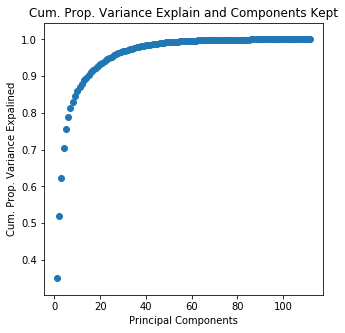

In [18]:
plt.rcParams['figure.figsize'] = [5,5]
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

## K Eigen values/vectors are kept

In [19]:
K = sum(np.cumsum(eigvalues_sort)/sum(eigvalues_sort)<precision)
K

46

## Weights Calculus

In [20]:
reduced_eig = np.array(eigvectors_sort[:K])
eig_trade = np.dot(reduced_eig,Phi_Mat_centered)
print(eig_trade.shape)
eig_trade

(46, 669)


array([[ 0.40519646,  0.46774012,  0.26012427, ..., -2.35959543,
        -1.82689639,  2.28854828],
       [ 0.51469808,  0.69149475,  0.71978623, ..., -0.99545439,
        -0.48561158, -2.13532142],
       [-2.20168453, -2.29292969, -2.42218741, ..., -0.14401934,
        -0.31331304,  0.18561534],
       ...,
       [ 0.04403674, -0.06073732, -0.09126691, ..., -0.11145632,
        -0.07305137,  0.06389189],
       [ 0.06275691,  0.13344271,  0.13803238, ...,  0.1468508 ,
         0.09770138, -0.0624072 ],
       [ 0.08111964,  0.08307811,  0.06894783, ...,  0.01534469,
         0.06496846, -0.05335658]])

In [21]:
all_together = pd.DataFrame(columns = hist_data[[x for x in hist_data.keys()][0]].index)

for ticker, df in hist_data.items():
    all_together = pd.concat([all_together, df.transpose()], axis=1, sort=False)
    all_together = all_together.dropna(axis = 1)
    all_together = all_together.dropna()
all_together

Date,2000-03-24 00:00:00,2000-03-27 00:00:00,2000-03-28 00:00:00,2000-03-29 00:00:00,2000-03-30 00:00:00,2000-03-31 00:00:00,2000-04-03 00:00:00,2000-04-04 00:00:00,2000-04-05 00:00:00,2000-04-06 00:00:00,...,2018-12-14 00:00:00,2018-12-17 00:00:00,2018-12-18 00:00:00,2018-12-24 00:00:00,2018-12-25 00:00:00,2018-12-26 00:00:00,2018-12-27 00:00:00,2018-12-28 00:00:00,2018-12-31 00:00:00,2019-01-01 00:00:00
Open,0.372878,0.333339,0.245765,0.316381,0.367237,0.372878,0.485871,0.564967,0.689259,0.598865,...,1.000000,0.990893,0.693989,0.284464,0.284464,0.000000,0.131238,0.231054,0.236599,0.236599
High,0.369833,0.298828,0.275160,0.363907,0.434912,0.434912,0.565088,0.718933,0.671596,0.612425,...,0.987090,0.958292,0.705065,0.277974,0.277974,0.000000,0.090815,0.212590,0.152735,0.152735
Low,0.392645,0.353106,0.344627,0.401125,0.474581,0.468922,0.545198,0.646894,0.723170,0.629936,...,1.000000,0.666019,0.605825,0.000000,0.000000,0.000000,0.103873,0.319542,0.274648,0.274648
Close,0.328719,0.281762,0.323203,0.411601,0.461317,0.459770,0.637922,0.752864,0.695393,0.620690,...,0.980251,0.651706,0.585278,0.000000,0.000000,0.130354,0.212291,0.236499,0.253259,0.253259
Volume,0.103042,0.010640,0.020660,0.002376,0.015805,0.210836,0.023243,0.409070,0.003616,0.012138,...,0.489913,0.635276,0.446206,0.418308,0.418308,0.653343,0.621469,0.372940,0.235336,0.235336
volume_adi,0.355597,0.362616,0.431565,0.455167,0.451674,0.443468,0.460672,0.629712,0.602796,0.431512,...,0.667679,0.359248,0.160573,0.090122,0.193934,0.684814,1.000000,0.666093,0.510632,0.677392
volume_obv,0.286177,0.271606,0.291592,0.301697,0.319060,0.196293,0.217675,0.447577,0.436802,0.421421,...,0.969559,0.933326,0.904979,0.754745,0.000000,0.791732,0.827389,0.852681,0.872232,0.000000
volume_cmf,0.619666,0.595692,0.603070,0.637737,0.565298,0.860071,1.000000,1.000000,0.967102,0.813789,...,0.703792,0.442025,0.391385,0.003924,0.000000,0.158986,0.232118,0.112773,0.071377,0.178887
volume_fi,0.455702,0.501827,0.482438,0.474817,0.476825,0.511781,0.485809,0.758851,0.474761,0.731815,...,0.704863,0.171625,0.719908,1.000000,0.764082,0.470753,0.499891,0.329861,0.362388,0.393908
volume_em,0.678160,0.749139,0.565059,0.848907,1.000000,1.000000,1.000000,1.000000,0.953531,0.763705,...,0.970082,0.586549,0.358041,0.000000,0.000000,0.000000,0.000000,0.086932,0.034342,0.026818


In [22]:
Recon = []
minESpace = []
allDistESpace = []

for i in range(all_together.shape[1]):
    ob_cent = all_together.iloc[:,i].values - phi_mean[:,0]
    weights = np.dot(reduced_eig,ob_cent).reshape((1,K))
    ghost_trade = np.dot(weights, reduced_eig).transpose() + phi_mean
    Recon.append(np.linalg.norm(all_together.iloc[:,i].values - ghost_trade))
    dist_list = [np.linalg.norm(eig_trade[:,j] - weights.transpose()) for j in range(eig_trade.shape[1])]
    minESpace.append(min(dist_list))
    allDistESpace.append(dist_list)
    

## $\epsilon$  for distances to the TradeSpace

In [23]:
eps_trdspace=np.percentile(minESpace,5)
print(eps_trdspace)

22.23143585254504


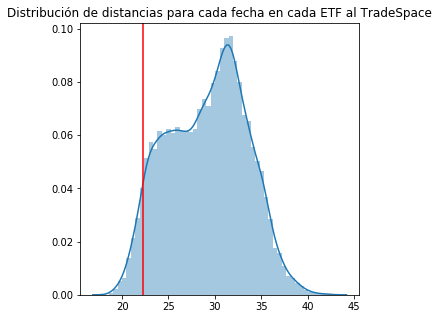

In [24]:
plt.rcParams['figure.figsize'] = [5,5]
sns.distplot(minESpace)
plt.axvline(x=eps_trdspace, color='r')
plt.title('Distribución de distancias para cada fecha en cada ETF al TradeSpace')
plt.show()

## $\epsilon$  for distances to the reconstruction of a trade

In [25]:
eps_recon=np.percentile(Recon,5)
print(eps_recon)

49.18837212902659


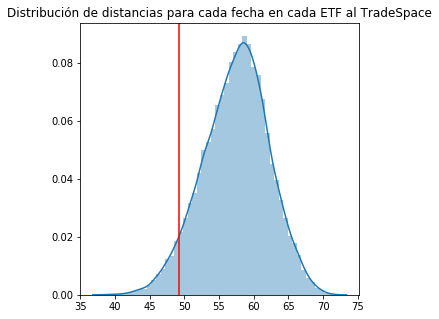

In [26]:
plt.rcParams['figure.figsize'] = [5,5]
sns.distplot(Recon)
plt.axvline(x=eps_recon, color='r')
plt.title('Distribución de distancias para cada fecha en cada ETF al TradeSpace')
plt.show()

In [29]:
(Recon<eps_recon).sum()/len(Recon)

0.05